# Cubic Splines with Node Sensitivities

## Motivation

In Finance, one works with curves A LOT. Reasonable interpolation schemes are important to get prices and their dynamics right. 

`scipy.interpolate` provides an amazing package for working with curves. So, I was surprised to find that interpolators, such as CubicSpline, do not provide the sensitivity of a point on the curve to a move in one of the nodes. This is particularly important during calibration.

To calibrate one's model of the market as a set of rate curves, one typically forms a Jacobian matrix of the sensitivity of the prices of the target instruments to each rate node in the model's curves. It is straightforward to compute the sensitivity of these instruments to the rates of the dates inherent to the instrument itself. The dates in all the instruments, however, do not line up, so we must interpolate.

Computation of the Jacobian looks something like this:

$$ \frac{\partial V_i}{\partial y_j} = \Sigma_k \frac{\partial V_i}{\partial y_k} \frac{\partial y_k}{\partial y_j} $$ 

## Calculating sensitivity of $y(x)$ to moves in $(x_i,y_i)$

It's the last term, $\frac{\partial y_k}{\partial y_j}$ , that represents the move in some arbitrary point in our curve to the node $j$. This is what I lacked in order to continue with the curve calibration module that I am building.

The approach that I have taken is to differentiate the Linear System used to compute the Spline itself, with respect to each of the nodes. SciPy follows the approach of setting up a system in terms of the first derivative, as in wikipedia's page on [CubicSplines](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline). By differentiating (15), one extends the dimension by one, so that $x$ and $b$ in $A x = b$ are matrices instead of vectors.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pennies.market.interpolate import CubicSplineWithNodeSens

### y = sin(x)

In [3]:
def f(x):
    return np.sin(x)

In [4]:
x = 0.5 * np.arange(10)
y = f(x)
for i in range(len(x)): 
    print('({},  {}'.format(x[i],y[i]))

(0.0,  0.0
(0.5,  0.479425538604203
(1.0,  0.8414709848078965
(1.5,  0.9974949866040544
(2.0,  0.9092974268256817
(2.5,  0.5984721441039564
(3.0,  0.1411200080598672
(3.5,  -0.35078322768961984
(4.0,  -0.7568024953079282
(4.5,  -0.977530117665097


In [5]:
cs_sens = CubicSplineWithNodeSens(x, y, bc_type='clamped')

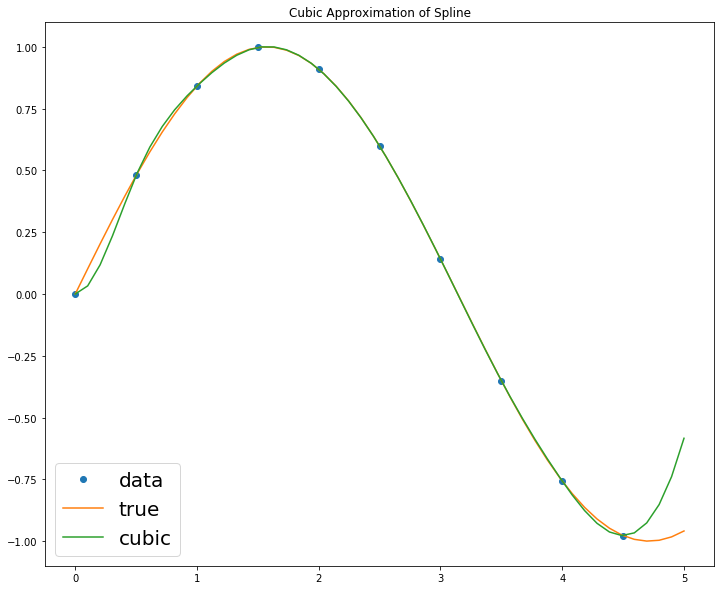

In [6]:
xs = np.linspace(0, 5)
plt.figure(figsize=(12,10))
plt.title('Cubic Approximation of Spline')
plt.plot(x, y, 'o', label='data')
plt.plot(xs, f(xs), label='true')
plt.plot(xs, cs_sens(xs), label='cubic')
plt.legend(loc='lower left', fontsize=20)
plt.show()

## Sensitivity to nodes: $\frac{\partial y(x)}{\partial y_i}$

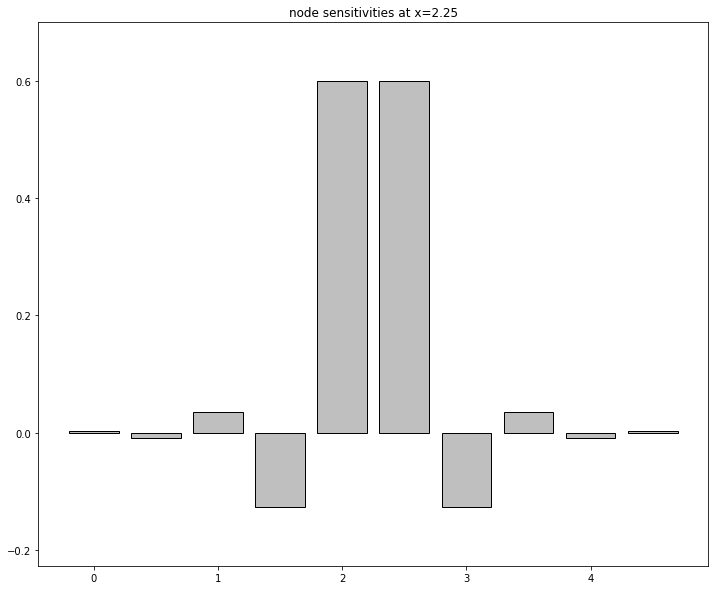

In [7]:
# Calculate the sensitivity of x1 to a unit move in each node in the curve (x,y) 
x1 = 2.25
y_sens = cs_sens.node_derivative(x1)

plt.figure(figsize=(12, 10))
plt.title('node sensitivities at x={}'.format(x1))
#plt.plot(x, y_sens, 'o', ms=10)
plt.bar(x, y_sens, width=0.4, color='0.75', edgecolor='k')
plt.ylim(min(y_sens) - 0.1, max(y_sens)+0.1)
plt.show()